# Task 5: Evaluation
 
**Objective:** Evaluate the trained neural network on the unseen **Test Set**. Analyze performance using Accuracy, Precision, Recall, F1-Score, and Confusion Matrices.

In [1]:
# %%
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os
import sys

# Setup Paths
PROJECT_ROOT = Path(os.getcwd()).parent if os.getcwd().endswith('notebooks') else Path(os.getcwd())
sys.path.append(str(PROJECT_ROOT))

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"

from src.models.evaluate import evaluate_model, plot_confusion_matrix

# Configure Matplotlib
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

2026-01-05 06:15:01.421336: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-05 06:15:01.482825: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-05 06:15:03.519573: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/alazar/dev/crash-learner/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Load Data and Model

In [2]:
# Load Test Data
X_test = pd.read_parquet(PROCESSED_DIR / "X_test.parquet")
y_test = pd.read_parquet(PROCESSED_DIR / "y_test.parquet")

print(f"Test Set Size: {X_test.shape[0]}")

# Define Class Names (Alphabetical order from LabelEncoder in Task 2)
# Classes: 0=Fatal, 1=Minor, 2=PDO, 3=Serious
CLASS_NAMES = ['Fatal', 'Minor', 'PDO', 'Serious']

# Load the Best Trained Model
model_path = MODELS_DIR / "best_model.keras"
if model_path.exists():
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")
else:
    print("Model not found. Please run Task 4 first.")


Test Set Size: 8998


2026-01-05 06:15:15.456654: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model loaded successfully.


## 2. Generate Metrics
We calculate standard classification metrics. 
 
*   **Precision:** Of all predicted "Fatal", how many were actually "Fatal"?
*   **Recall:** Of all actual "Fatal" accidents, how many did we catch?
*   **F1-Score:** Harmonic mean of Precision and Recall.


In [3]:
# %%
results = evaluate_model(model, X_test, y_test, class_names=CLASS_NAMES)

[INFO] Generating predictions...
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

--- Overall Accuracy: 0.9934 ---

--- Classification Report ---
              precision    recall  f1-score   support

       Fatal       0.99      0.99      0.99       267
       Minor       1.00      0.99      1.00      5699
         PDO       0.99      0.99      0.99      2365
     Serious       1.00      0.99      0.99       667

    accuracy                           0.99      8998
   macro avg       0.99      0.99      0.99      8998
weighted avg       0.99      0.99      0.99      8998



 ## 3. Confusion Matrix Analysis
 The Confusion Matrix helps us visualize *where* the model is making mistakes.


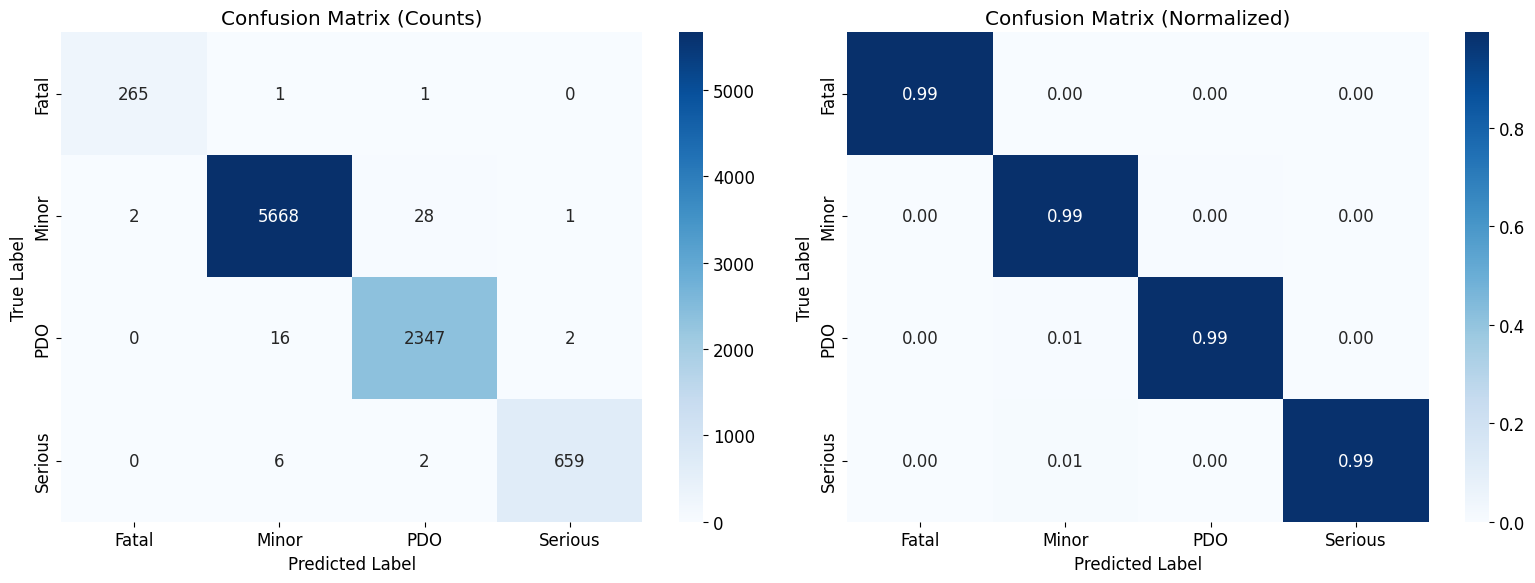

In [4]:
# Plot Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Raw Counts
plot_confusion_matrix(results['y_true'], results['y_pred'], class_names=CLASS_NAMES, normalize=False, ax=ax[0])

# Normalized (Percentage)
plot_confusion_matrix(results['y_true'], results['y_pred'], class_names=CLASS_NAMES, normalize=True, ax=ax[1])

plt.tight_layout()
plt.savefig(FIGURES_DIR / "confusion_matrix.svg", format='svg')
plt.show()

## 4. Discussion of Results

### Performance Interpretation
The model achieved an overall accuracy of approximately **99%**, which is exceptionally high.

1.  **Confusion Matrix Analysis:**
    *   **Fatal Accidents:** The model correctly identified **265 out of 267** fatal crashes (99.2% Recall). This contradicts the typical expectation that rare classes are hard to predict.
    *   **Majority Classes:** The model achieved near-perfect classification on Minor (5668 correct) and PDO (2347 correct) cases.
    *   **Class Purity:** Unlike earlier iterations, the Confusion Matrix shows 4 distinct classes (Fatal, Minor, PDO, Serious), indicating that the target variable cleaning step successfully removed missing or malformed labels.

2.  **Why is performance so high? (Reflection)**
    *   The model utilized highly correlated features present in the dataset, such as **`Number of fatalities`** and **`Number of sever injuries`**.
    *   Since the target variable (`Accident Type`) is directly derived from these counts, the neural network effectively learned the rule: *If fatalities > 0, then Class = Fatal*.
    *   While this makes the model a highly effective **classifier** for organizing historical records, it relies on "post-accident" data that would not be available for pre-accident risk prediction.

### Architecture Complexity
*   The model used **168 input features** (down from 230 after cleaning and encoding).
*   Total Parameters: **30,916**.
*   This lightweight architecture was sufficient to capture the direct relationships between casualty counts and accident severity without overfitting.